## Initializing

In [5]:
# downgrade version w.r.t. the implementation date 2019/06/13
!pip install -q flair==0.4.2 # https://github.com/flairNLP/flair/releases/tag/v0.4.2
# !pip uninstall scikit-learn
# !pip install -q scikit-learn==0.21.2 # https://scikit-learn.org/stable/whats_new/v0.21.html#version-0-21-2
# !pip uninstall numpy
# !pip install -q numpy==1.16.4 # https://pypi.org/project/numpy/#history
# !pip uninstall torch
# !pip install -q torch==1.1.0 # https://github.com/pytorch/pytorch/releases?page=2
# !pip uninstall nltk
# !pip install -q nltk==3.4.3 # https://pypi.org/project/nltk/#history

In [6]:
from flair.embeddings import BertEmbeddings
from flair.data import Sentence
embedding = BertEmbeddings('bert-large-uncased', layers = '23')
embedding2 = BertEmbeddings('bert-large-uncased', layers = '1')

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
t = np.transpose
%matplotlib inline

In [8]:
from tqdm.notebook import tqdm
# from tqdm import tqdm_notebook as tqdm
import nltk
nltk.download('brown')

from nltk.corpus import brown
brown_corpus = brown.sents()
brown_corpus = brown_corpus[:20000]

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [9]:
brown_e = []
brown_e2 = []
for s in tqdm(brown_corpus):
    sentence = Sentence(' '.join(s))
    embedding.embed(sentence)
    # sent_emb = torch.stack([token.embedding for token in sentence]).cpu().numpy()
    sent_emb = torch.stack([token.embedding for token in sentence]).numpy()
    brown_e.append(sent_emb)
    sentence = Sentence(' '.join(s))
    embedding2.embed(sentence)
    # sent_emb = torch.stack([token.embedding for token in sentence]).cpu().numpy()
    sent_emb = torch.stack([token.embedding for token in sentence]).numpy()
    brown_e2.append(sent_emb)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [10]:
from google.colab import drive
import os

path = '/content/drive/My Drive/...'
drive.mount('/content/drive', force_remount=True) 

os.makedirs(path, exist_ok=True)
os.chdir(path)

Mounted at /content/drive


In [14]:
# Save to gdrive and reload from gdrive

# np.save(f'{path}/brown_e.npy', brown_e, allow_pickle=True)
# np.save(f'{path}/brown_e2.npy', brown_e2, allow_pickle=True)

# brown_e = np.load(f'{path}/brown_e.npy', allow_pickle=True)
# brown_e2 = np.load(f'{path}/brown_e2.npy', allow_pickle=True)

In [15]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse as ellipse
from scipy.spatial.distance import pdist

np.set_printoptions(suppress=True)
np.set_printoptions(precision=14)
plt_style = 'seaborn-talk'

# Experimental: HDBScan is a state-of-the-art clustering algorithm
hdbscan_available = True
try:
    import hdbscan
except ImportError:
    hdbscan_available = False

In [108]:
def do_plot(X_fit, title=None, labels = [''], circ = False, legend = True):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0,1,num_labels))
    print(X_fit.shape, label_types)
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 1:
            ax = fig.add_subplot(111)
            for lab,col in zip(label_types, colors):
                if num_labels>1:
                    idxs = [i for i,v in enumerate(labels) if v == lab]
                    ax.scatter([X_fit[i,0] for i in idxs], 
                               [0 for _ in range(len(idxs))], 
                               c = [col], label = lab)
                else:
                    ax.scatter(X_fit[:,0],
                               np.zeros_like(X_fit),
                               c = [col])
        elif dimension == 2:
            ax = fig.add_subplot(111)
            for lab,col in zip(label_types, colors):
                if num_labels>1:
                    idxs = [i for i,v in enumerate(labels) if v == lab]
                    ax.scatter([X_fit[i,0] for i in idxs], 
                               [X_fit[i,1] for i in idxs], 
                               c = [col], label = lab)
                else:
                    ax.scatter(X_fit[:,0],
                               X_fit[:,1],
                               c = [col])
        elif dimension == 3:
            ax = fig.add_subplot(111, projection ='3d')
            for lab, col in zip(label_types,colors):
                ax.scatter(X_fit[labels==lab,0],
                           X_fit[labels==lab,1],
                           X_fit[labels==lab,2],
                           c=[col])
        else:
            raise Exception('Bad Dimensions')
        plt.title(title)
        if num_labels >1 and legend:
            ax.legend()
        if circ:
            circ = ellipse((0,0),2,2, edgecolor = 'k', facecolor = 'none')
            ax.add_artist(circ)
            plt.xlim((-1,1))
            plt.ylim((-1,1))
        plt.show()

In [17]:
def pick_embeddings(corpus,sent_embs,word_list):
    X = []
    labels = []
    sents = []
    for i, s in enumerate(corpus):
        for j, w in enumerate(s):
            if w in word_list:
                X.append(sent_embs[i][j])
                labels.append(w)
                sents.append(s)
    return (X, labels, sents)

## Visualizations

[0.10686418       0.05781726       0.035956252      ... 0.000011616074
 0.00001013469    0.00000000681638]
(266, 2) ['children', 'executive', 'marriage', 'professional']


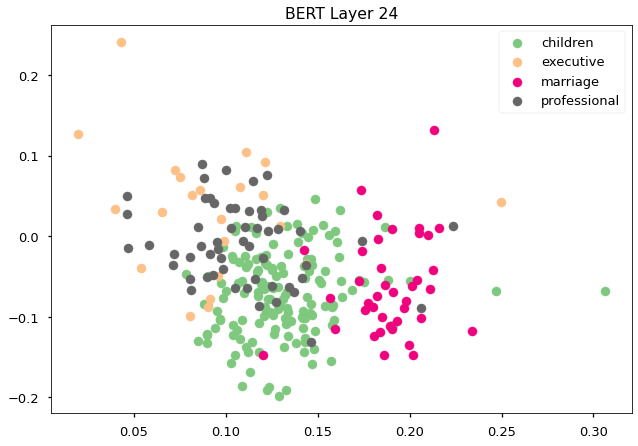

(4705, 2) ['John', 'Mary', 'he', 'husband', 'it', 'she', 'wife']


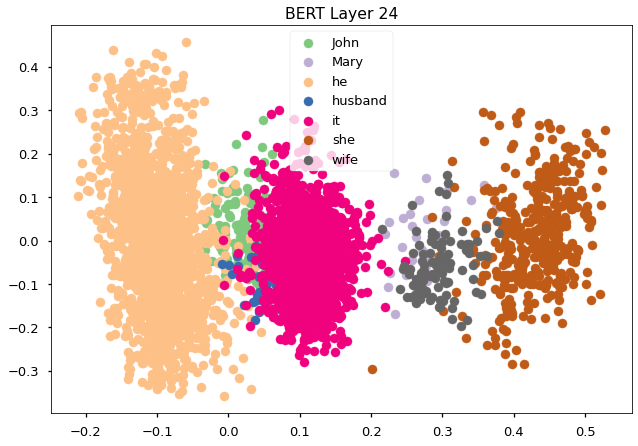

In [18]:
X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['he','she'])
X = np.asarray(X)
norm = np.apply_along_axis(np.linalg.norm, 1, X)
X = X / norm[:, None]
pca = PCA()
pca.fit(X)
print(pca.explained_variance_ratio_)
r1 = 0
r2 = r1 + 2

X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['executive','professional', 'marriage', 'children'])
X = np.asarray(X)
norm = np.apply_along_axis(np.linalg.norm, 1, X)
X = X / norm[:, None]
do_plot(pca.transform(X)[:,r1:r2], 'BERT Layer 24', labels = labels)


X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['husband', 'wife', 'Mary', 'John', 'he','she','it'])
X = np.asarray(X)
norm = np.apply_along_axis(np.linalg.norm, 1, X)
X = X / norm[:, None]


do_plot(pca.transform(X)[:,r1:r2], 'BERT Layer 24', labels=labels, circ = False)

Fit Shape
(615, 1024)
Explained Variance
[0.000006351772   0.0000062537547  0.0000058573746  0.000005802858
 0.0000055360333  0.000005102154   0.000004942452   0.000004625398
 0.000004532909   0.00000000000061]
Singular Values
[0.40316856    0.40004572    0.3871602     0.38535428    0.37639043
 0.36133996    0.35563987    0.34404382    0.34058672    0.00012536277]
(615, 1) ['He']


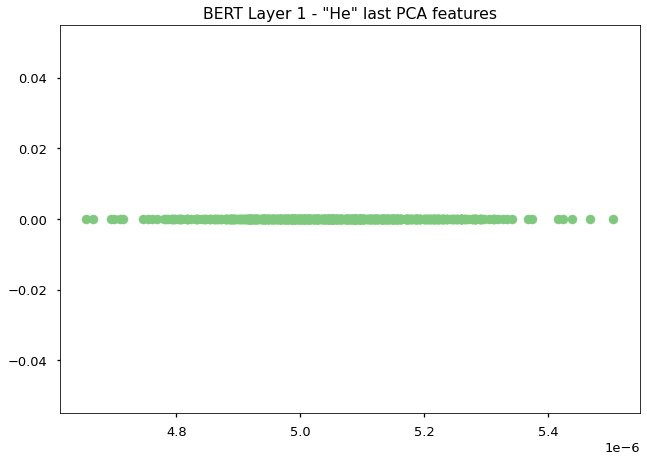

[0.2170267  0.06180582]
(89, 2) ['doctor', 'executive', 'marriage', 'nurse']


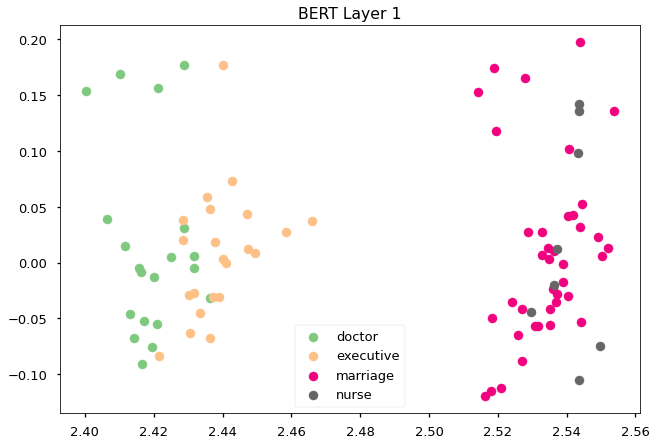

(4803, 2) ['John', 'Mary', 'father', 'he', 'husband', 'it', 'mother', 'she', 'wife']


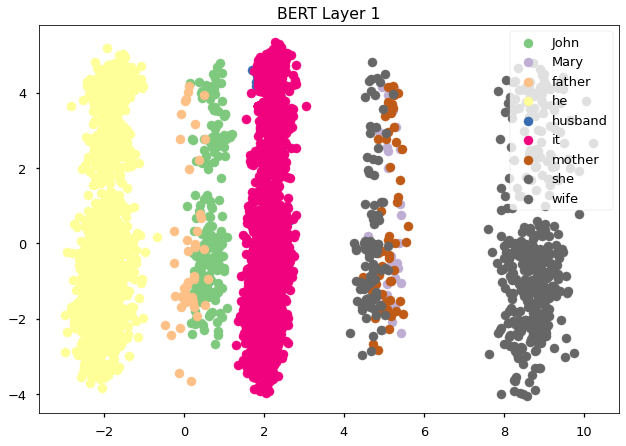

(2263, 2) ['dog', 'fly', 'he', 'run', 'she', 'walk']


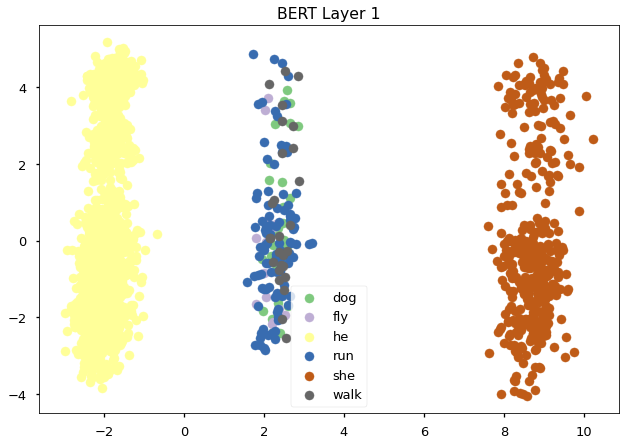

In [89]:
X, labels, _ = pick_embeddings(brown_corpus, brown_e2, ['He'])
X = np.asarray(X)
m = np.mean(X, axis = 0).size
pca = PCA()
pca.fit(X)
print('Fit Shape')
print(X.shape)
print('Explained Variance')
print(pca.explained_variance_ratio_[-10:])
print('Singular Values')
print(pca.singular_values_[-10:])

do_plot(pca.transform(X)[:,-1:],'BERT Layer 1 - "He" last PCA features', labels=labels, circ = False)

X, labels, _ = pick_embeddings(brown_corpus, brown_e2, ['he', 'she'])
X = np.asarray(X)
# norm = np.apply_along_axis(np.linalg.norm, 1, X)
# X = X / norm[:, None]
pca = PCA(n_components = 2)
pca.fit(X)
print(pca.explained_variance_ratio_)

X, labels, _ = pick_embeddings(brown_corpus, brown_e2, ['executive', 'marriage', 'doctor', 'nurse'])
X = np.asarray(X)
norm = np.apply_along_axis(np.linalg.norm, 1, X)
X = X / norm[:, None]
do_plot(pca.transform(X), 'BERT Layer 1', labels = labels)


X, labels, _ = pick_embeddings(brown_corpus, brown_e2, ['husband', 'wife', 'Mary', 'John','father','mother','he','she','it'])
X = np.asarray(X)
# norm = np.apply_along_axis(np.linalg.norm, 1, X)
# X = X / norm[:, None]


do_plot(pca.transform(X), 'BERT Layer 1', labels=labels, circ = False)

X, labels, _ = pick_embeddings(brown_corpus, brown_e2, ['run','walk','dog','fly','he','she'])
X = np.asarray(X)
# norm = np.apply_along_axis(np.linalg.norm, 1, X)
# X = X / norm[:, None]


do_plot(pca.transform(X), 'BERT Layer 1', labels=labels, circ = False)

In [ ]:
X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['it'])
X = np.asarray(X)
m = np.mean(X, axis = 0).size
pca = PCA()
pca.fit(X)
print('Fit Shape')
print(X.shape)
print('Explained Variance')
print(pca.explained_variance_ratio_[-10:])
print('Singular Values')
print(pca.singular_values_[-10:])
trans = pca.components_[-2:]
print('Component Norms')
print(np.apply_along_axis(np.linalg.norm, 1, trans))
smin = 1 / pca.singular_values_[-1]

# d1 = -1
# d2 = d1 + 1

Fit Shape
(2231, 1024)
Explained Variance
[0.00001742955    0.000017375223   0.000017024851   0.000016880324
 0.000016734526   0.000016259113   0.000015976546   0.000015712898
 0.000014494386   0.00000000000001]
Singular Values
[2.2230651      2.2195978      2.1971047      2.187759
 2.1782906      2.147126       2.1283867      2.110752
 2.027258       0.000060806848]
Component Norms
[1.0000001 1.0000001]


Fit Shape
(2231, 1024)
Explained Variance
[0.000017429467   0.000017375196   0.00001702485    0.000016880278
 0.000016734517   0.000016259059   0.000015976477   0.000015712887
 0.000014494344   0.00000000000001]
Singular Values
[2.2230601     2.2195964     2.197105      2.1877563     2.1782904
 2.1471226     2.1283824     2.1107516     2.0272553     0.00006080695]
Component Norms
[0.9999998 0.9999997]
(2231, 1) ['it']


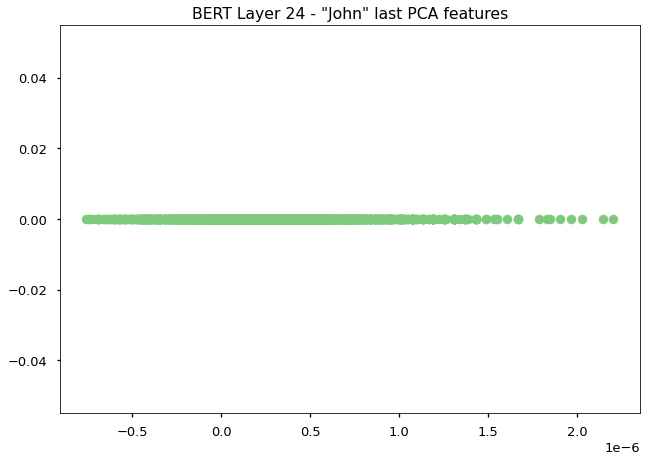

(2179, 1) ['he', 'she', 'thing']


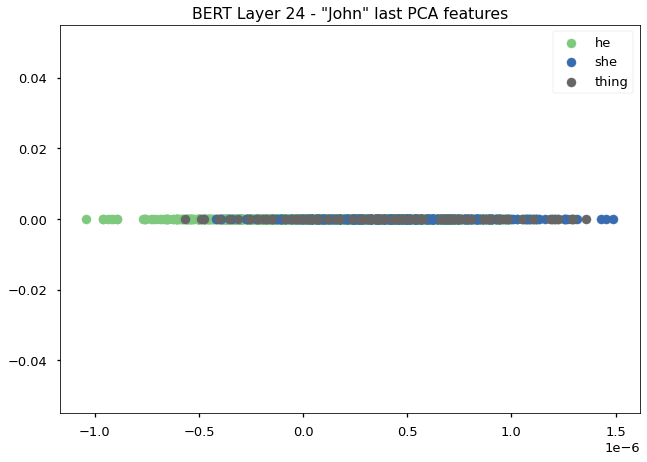

2.574116e-07
1.5344955e-13


In [109]:
X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['it'])
X = np.asarray(X)
m = np.mean(X, axis = 0).size
pca = PCA()
pca.fit(X)
print('Fit Shape')
print(X.shape)
print('Explained Variance')
print(pca.explained_variance_ratio_[-10:])
print('Singular Values')
print(pca.singular_values_[-10:])
trans = pca.components_[-2:]
print('Component Norms')
print(np.apply_along_axis(np.linalg.norm, 1, trans))
smin = 1 / pca.singular_values_[-1]

# X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['he'])
# X = np.asarray(X)

# plt.hist(pca.transform(X)[:,-1]*smin,bins = 20)
# plt.show()

# X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['she'])
# X = np.asarray(X)



# plt.hist(pca.transform(X)[:,-1]*smin,bins = 20)
# plt.show()

d1 = -1
d2 = d1 + 1

do_plot(pca.transform(X)[:,d1:],'BERT Layer 24 - "John" last PCA features', circ = False, labels = labels)

X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['he','thing', 'she'])
X = np.asarray(X)
Y = X @ trans.T

# X = np.concatenate(brown_e)


do_plot(pca.transform(X)[:,d1:],'BERT Layer 24 - "John" last PCA features', circ = False, labels = labels)
print(np.mean(pca.transform(X)[:,-1]))
print(np.var(pca.transform(X)[:,-1]))

In [ ]:
wordlist = ['John','bad','he','she','it','dog','run','family','executive','good', 'Mary', 'walk', 'husband', 'mother', 'wife', 'father']
variance_ratios = []
for word in tqdm(wordlist): 
    X, labels, _ = pick_embeddings(brown_corpus, brown_e, [word])
    X = np.asarray(X)
    pca = PCA()
    pca.fit(X)
    variance_ratios.append(pca.explained_variance_ratio_[-1]/pca.explained_variance_ratio_[-2])
    
print('\n',variance_ratios)
print(np.format_float_scientific(np.mean(variance_ratios[1:])))



 [0.004938514, 4.8285638e-12, 2.8271527e-10, 4.923202e-09, 8.996843e-10, 1.2047877e-11, 2.20368e-11, 1.9479449e-10, 7.66861e-13, 1.6471031e-09, 2.773682e-12, 3.2992743e-12, 1.8582077e-11, 9.22324e-12, 4.2842833e-11, 1.7613976e-11]
5.3876764e-10


## Cosine PCA and LDA

(2186, 2) ['father', 'he', 'mother', 'she']


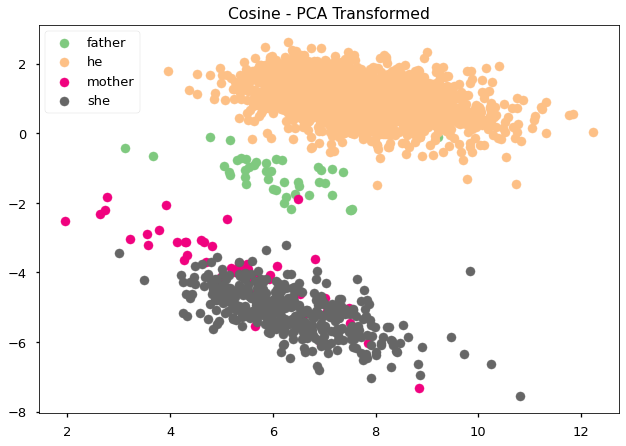

(4319, 2) ['he', 'it', 'she']


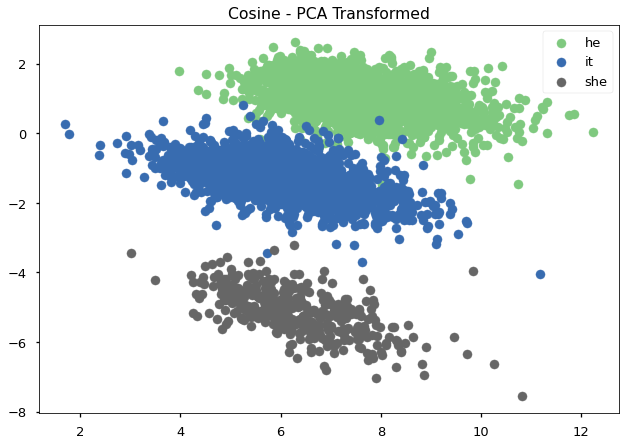

In [110]:
from sklearn.metrics.pairwise import cosine_similarity
X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['he','she','father','mother'])
X = np.asarray(X)
m = np.mean(X, axis = 0).size
# X = X - m

cov = cosine_similarity(X.T)
eig, vec = np.linalg.eig(cov)

trans = vec[:,0:2]

do_plot(X @ trans,'Cosine - PCA Transformed', circ = False, labels = labels)

X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['he','she','it'])
X = np.asarray(X)
# X = X - m

do_plot(X @ trans,'Cosine - PCA Transformed', circ = False, labels = labels)

(5224, 2)
(5224, 2) ['John', 'Mary', 'aunt', 'brother', 'father', 'grandfather', 'grandmother', 'he', 'her', 'hers', 'him', 'his', 'mother', 'she', 'sister', 'uncle']


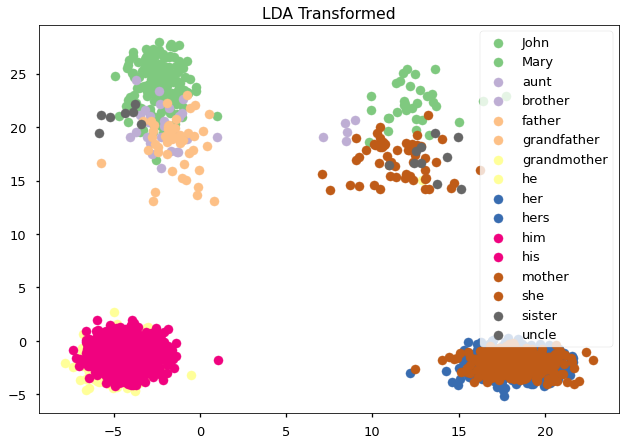

(2735, 2) ['bad', 'dog', 'family', 'good', 'he', 'professional', 'she']


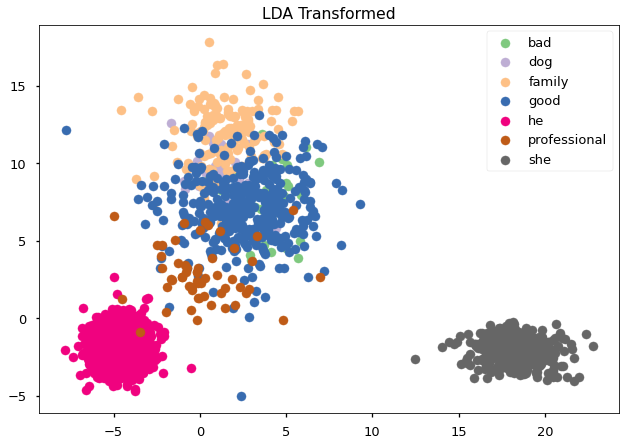

In [111]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 2)

X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['he','she','him','her','his','hers','uncle','aunt','grandmother','grandfather','John','Mary','mother','father','brother','sister'])
X = np.asarray(X)

lda.fit(X, labels)
print(lda.transform(X).shape)
do_plot(lda.transform(X),'LDA Transformed', circ = False, labels = labels)

X, labels, _ = pick_embeddings(brown_corpus, brown_e, ['he','she', 'family','professional','good','bad','dog'])
X = np.asarray(X)

do_plot(lda.transform(X),'LDA Transformed', circ = False, labels = labels)

## Using Plotly

In [112]:
!pip install -q plotly

In [113]:
import plotly as py
print(py.__version__)

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

5.5.0


In [114]:
configure_plotly_browser_state()

def wordlist_scatter(corpus, embedding, wordlist, component1 = 0, component2 = 1, title = 'PCA'):
    
    X,_,_ = pick_embeddings(corpus, embedding, wordlist)
    X = np.asarray(X)
    pca = PCA()
    pca.fit(X)
    
    data = []
    for word in wordlist:
        X, _, _ = pick_embeddings(corpus, embedding, [word])
        X = np.asarray(X)
        
        trans = pca.transform(X)

        trace = go.Scattergl(
            x = trans[:,component1],
            y = trans[:,component2],
            name = word,
            mode = 'markers',
            text= word
        )
        
        data.append(trace)
        
    layout= go.Layout(
        title= 'PCA',
        hovermode= 'closest',
    )
    
    fig= go.Figure(data=data, layout=layout)
    iplot(fig)
    
    return

wordlist_scatter(brown_corpus, brown_e, ['he','she'])

In [115]:
!nvidia-smi

Sat Jan 29 09:59:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   4249MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------